# Flight Delays and Cancellations
The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

### References
* https://www.kaggle.com/datasets/usdot/flight-delays

In [1]:
import datetime

# Import numpy
import numpy as np

# Import pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Apply the default theme
sns.set_theme()

# ignore warnings on data imports
import warnings
warnings.filterwarnings('ignore')

# Import scikit-learn
# from sklearn.cluster import KMeans

# Loading the data

In [2]:
airlines = pd.read_csv('../data/airlines.csv')
airlines.shape

(14, 2)

In [3]:
airports = pd.read_csv('../data/airports.csv')
airports.shape

(322, 7)

In [4]:
flights = pd.read_csv('../data/flights.csv')
flights.shape

(5819079, 31)

# Understanding the data

### Airline Fact Table
`airlines` is a map of airline codes to airline names. 

In [5]:
airlines.head(2)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.


### Airport Fact Table
`airports` maps airport codes to facts about an airport (including location information)

In [6]:
airports.head(2)
# use geopandas here?

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819


### Flight Delays & Cancellations

`flights` contains 5.8 million rows of flight delay and cancellation information. 

| Feature | Description |
|:-------|:------------|
| `YEAR` | Year of the Flight Trip|
| `MONTH`| Month of the Flight Trip|
| `DAY`| Day of the Flight Trip|
| `DAY_OF_WEEK`| Day of week of the Flight Trip|
| `AIRLINE`|Airline Identifier |
| `FLIGHT_NUMBER`| Flight Identifier|
| `TAIL_NUMBER`| Aircraft Identifier|
| `ORIGIN_AIRPORT`| Starting Airport|
| `DESTINATION_AIRPORT`| Destination Airport|
| `SCHEDULED_DEPARTURE`| Planned Departure Time|
| `DEPARTURE_TIME`| WHEEL_OFF - TAXI_OUT|
| `DEPARTURE_DELAY`| Total Delay on Departure|
| `TAXI_OUT`| The time duration elapsed between departure from the origin airport gate and wheels off|
| `WHEELS_OFF`| The time point that the aircraft's wheels leave the ground|
| `SCHEDULED_TIME`| Planned time amount needed for the flight trip|
| `ELAPSED_TIME`| AIR_TIME+TAXI_IN+TAXI_OUT|
| `AIR_TIME`| The time duration between wheels_off and wheels_on time|
| `DISTANCE`| Distance between two airports|
| `WHEELS_ON`| The time point that the aircraft's wheels touch on the ground|
| `TAXI_IN`| The time duration elapsed between wheels-on and gate arrival at the destination airport|
| `SCHEDULED_ARRIVAL`| Planned arrival time|
| `ARRIVAL_TIME`| WHEELS_ON+TAXI_IN|
| `ARRIVAL_DELAY`| ARRIVAL_TIME-SCHEDULED_ARRIVAL|
| `DIVERTED`| Aircraft landed on airport that out of schedule|
| `CANCELLED`| Flight Cancelled (1 = cancelled)|
| `CANCELLATION_REASON`| Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security|
| `AIR_SYSTEM_DELAY`| Delay caused by air system|
| `SECURITY_DELAY`| Delay caused by security|
| `AIRLINE_DELAY`| Delay caused by the airline|
| `LATE_AIRCRAFT_DELAY`| Delay caused by aircraft|
| `WEATHER_DELAY`| Delay caused by weather| 
<br />

# flights.csv transformations


In [7]:
flights.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


* To aid development of this model, we choose to only work with Janurary 2015.
* Create a datetime column from other columns

In [8]:
# flights = flights[flights['MONTH'] == 1]

flights['date'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])

flights = flights.drop(['YEAR', 'MONTH', 'DAY'], axis=1)

* Restrict data frame to the columns we care to examine and make all lowercase.

In [9]:
flights = flights[[
    # flight metadata
    'AIRLINE', 
    'ORIGIN_AIRPORT', 
    'DESTINATION_AIRPORT',
    
    # flight length metrics
    'SCHEDULED_TIME',
    'ELAPSED_TIME',
    
    # flight departure metrics
    'SCHEDULED_DEPARTURE', 
    'DEPARTURE_DELAY',
    
    # flight arrival metrics
    'ARRIVAL_DELAY',
    
    # used for future transforms
    'date'
]]

flights.columns = [x.lower() for x in flights.columns]

In [10]:
flights.head()

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay,date
0,AS,ANC,SEA,205.0,194.0,5,-11.0,-22.0,2015-01-01
1,AA,LAX,PBI,280.0,279.0,10,-8.0,-9.0,2015-01-01
2,US,SFO,CLT,286.0,293.0,20,-2.0,5.0,2015-01-01
3,AA,LAX,MIA,285.0,281.0,20,-5.0,-9.0,2015-01-01
4,AS,SEA,ANC,235.0,215.0,25,-1.0,-21.0,2015-01-01


Convert other date time related columns to useful values through a few transformations

In [11]:
# Function that convert the 'HHMM' string to datetime.time
# credit: https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        try:
            if chaine == 2400: chaine = 0
            d = f'{int(chaine):0>4}'
            heure = datetime.time(int(d[0:2]), int(d[2:4]))
        except:
            raise ValueError(chaine)
        return heure

# Function that merges "date" and "SCHEDULED_DEPARTURE"
# credit: https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial
def format_combine(row):
    d = row['date']
    t = row['scheduled_departure']
    
    if pd.isnull(d) or pd.isnull(t):
        return np.nan
    
    if float(t) == 2400:
        d += datetime.timedelta(days=1)
        t = datetime.time(0, 0)
    else:
        t = format_heure(t)
    
    return datetime.datetime.combine(d, t)

In [12]:
flights['scheduled_departure'] = flights.apply(format_combine, axis=1)

In [13]:
flights = flights = flights.drop(['date'], axis=1)

Drop any NaN values across the dataset. 

In [14]:
print(len(flights))
flights.dropna(inplace = True)
print(len(flights))

5819079
5714008


In [15]:
flights.head(2)

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,AS,ANC,SEA,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,AA,LAX,PBI,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0


## Join with airline dataset to create better labeled visualizations

In [16]:
flights = flights.merge(airlines, how='left', left_on='airline', right_on='IATA_CODE')
flights.rename(columns = {'AIRLINE':'airline_name'}, inplace = True)
flights = flights.drop(columns=['IATA_CODE'], axis=1)

In [17]:
flights = flights[[
    'airline', 
    'airline_name', 
    'origin_airport', 
    'destination_airport', 
    'scheduled_time', 
    'elapsed_time',
    'scheduled_departure',
    'departure_delay',
    'arrival_delay'
]]

In [18]:
flights.head(10)

,airline,airline_name,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,AS,Alaska Airlines Inc.,ANC,SEA,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,AA,American Airlines Inc.,LAX,PBI,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0
2,US,US Airways Inc.,SFO,CLT,286.0,293.0,2015-01-01 00:20:00,-2.0,5.0
3,AA,American Airlines Inc.,LAX,MIA,285.0,281.0,2015-01-01 00:20:00,-5.0,-9.0
4,AS,Alaska Airlines Inc.,SEA,ANC,235.0,215.0,2015-01-01 00:25:00,-1.0,-21.0
5,DL,Delta Air Lines Inc.,SFO,MSP,217.0,230.0,2015-01-01 00:25:00,-5.0,8.0
6,NK,Spirit Air Lines,LAS,MSP,181.0,170.0,2015-01-01 00:25:00,-6.0,-17.0
7,US,US Airways Inc.,LAX,CLT,273.0,249.0,2015-01-01 00:30:00,14.0,-10.0
8,AA,American Airlines Inc.,SFO,DFW,195.0,193.0,2015-01-01 00:30:00,-11.0,-13.0
9,DL,Delta Air Lines Inc.,LAS,ATL,221.0,203.0,2015-01-01 00:30:00,3.0,-15.0


# January 2015 Departure & Arrival Delays

In [19]:
jandf = flights[ flights['scheduled_departure'].apply(lambda x: x.month == 1)  ]

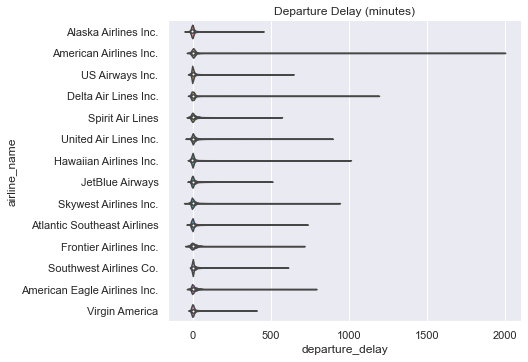

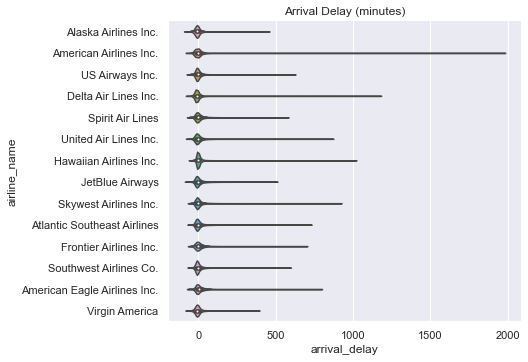

In [20]:
swarm = sns.catplot(
    data=jandf,
    kind="violin",
    y="airline_name",
    x="departure_delay",
    aspect=1.5,
    orient='h',
).set(title="Departure Delay (minutes)")

swarm = sns.catplot(
    data=jandf,
    kind="violin",
    y="airline_name",
    x="arrival_delay",
    aspect=1.5,
    orient='h',
).set(title="Arrival Delay (minutes)")

Create a categorical column from `arrival_delay`

In [21]:
def create_delay_level(x):
    if x < 5:
        return 'on time'
    if x < 45:
        return 'small delay'
    return 'long delay'

jandf['delay_level'] = jandf['arrival_delay'].apply(create_delay_level)

Aggregate by airline

In [22]:
g = jandf.groupby(['airline_name', 'delay_level']).size().reset_index()
g.columns = ['airline_name', 'delay_level', 'count']

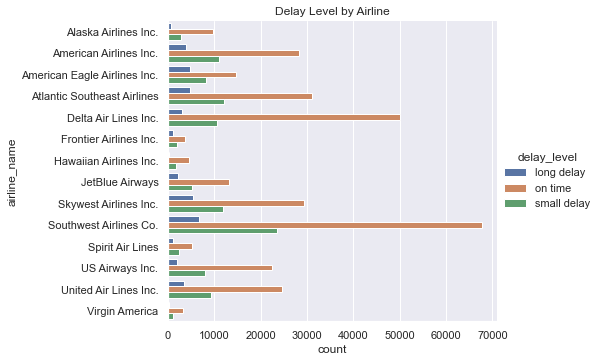

In [23]:
bar = sns.catplot(
    data=g, 
    x="count", 
    y="airline_name", 
    hue="delay_level", 
    kind="bar",
    aspect=1.5
).set(
    title="Delay Level by Airline"
)

# Departure & Arrival Delays by Airline

In [24]:
# month = flights['scheduled_departure'].dt.strftime('%b')
month_num = flights['scheduled_departure'].dt.month

avg_delay = flights.groupby([month_num, 'airline_name', 'airline']).mean().reset_index()

avg_delay = avg_delay.rename(columns={'scheduled_departure': 'month_num'})

avg_delay['month'] = avg_delay['month_num'].apply(lambda x: datetime.datetime.strptime(str(x), '%m').strftime('%b'))

avg_delay.sample(10)

,month_num,airline_name,airline,scheduled_time,elapsed_time,departure_delay,arrival_delay,month
152,12,Atlantic Southeast Airlines,EV,98.468277,95.375018,9.778435,6.685176,Dec
22,2,Skywest Airlines Inc.,OO,101.426724,100.112511,10.903107,9.588895,Feb
111,9,American Airlines Inc.,AA,167.156994,160.783284,4.940978,-1.432732,Sep
31,3,Atlantic Southeast Airlines,EV,100.159267,98.072116,8.817253,6.730101,Mar
28,3,Alaska Airlines Inc.,AS,183.905396,180.352916,3.007749,-0.544731,Mar
83,6,Virgin America,VX,208.063899,205.138129,8.705185,5.779415,Jun
2,1,American Eagle Airlines Inc.,MQ,95.000145,97.169254,15.995865,18.164974,Jan
90,7,Hawaiian Airlines Inc.,HA,102.865196,104.181805,0.684977,2.001586,Jul
3,1,Atlantic Southeast Airlines,EV,100.138508,98.997109,9.678895,8.537497,Jan
125,10,American Eagle Airlines Inc.,MQ,94.825400,87.723743,3.366604,-3.735054,Oct


For bar plots, it is difficult to visualize all of the airlines in a single chart 

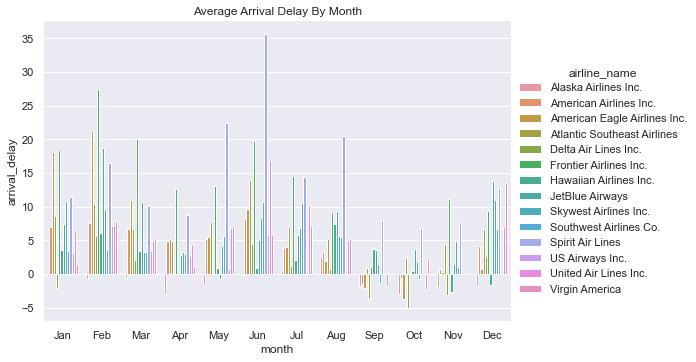

In [25]:
bar = sns.catplot(
    data=avg_delay, 
    x="month", 
    y="arrival_delay", 
    hue='airline_name',
    kind="bar",
    aspect=1.5
).set(
    title="Average Arrival Delay By Month"
)

# Heatmaps
It is easier to visualize this data as a heatmap. ( https://seaborn.pydata.org/generated/seaborn.heatmap.html )

### Reshape the data

In [26]:
h = avg_delay.set_index(['month_num', 'airline_name'])['arrival_delay'].unstack()
h

airline_name,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
month_num,,,,,,,,,,,,,,
1,-0.320888,6.955843,18.164974,8.537497,-2.043847,18.357238,3.512640,7.347281,10.889894,3.389466,11.398054,3.107457,6.352729,1.420702
2,-0.782923,7.530204,21.301627,10.417236,5.614745,27.424179,6.029967,18.657673,9.588895,3.501363,16.474466,7.114455,7.260662,7.784410
3,-0.544731,6.693587,11.018418,6.730101,2.077965,20.074855,3.468383,10.741317,3.181693,3.263341,10.039118,3.330787,4.892212,5.348207
4,-3.009003,4.931778,5.131228,4.821253,0.083343,12.640440,0.011022,2.780105,3.223796,2.996399,8.766224,2.660290,4.376092,0.995507
5,-1.716398,5.173878,5.466790,7.724290,0.149333,13.007554,0.826426,-0.709019,4.141162,5.680777,22.397347,0.681605,6.827695,7.102021
6,-0.220621,8.191017,9.639323,13.952793,4.419594,19.712951,0.882786,5.047155,8.338477,10.743462,35.561501,5.766296,16.932663,5.779415
7,0.377408,3.870440,3.980289,6.926421,1.204862,14.464543,2.001586,5.841454,6.790333,10.504942,14.352382,NaN,10.262551,7.135773
8,2.503899,3.193907,1.896565,5.154422,0.653114,9.175737,7.448029,9.280950,5.606689,5.532108,20.519018,NaN,5.014041,5.106221
9,-1.813800,-1.432732,-2.167268,0.851062,-3.703377,0.978460,3.696915,3.539154,1.530896,-1.336260,8.000101,NaN,-1.794265,0.070998


### Plot the data

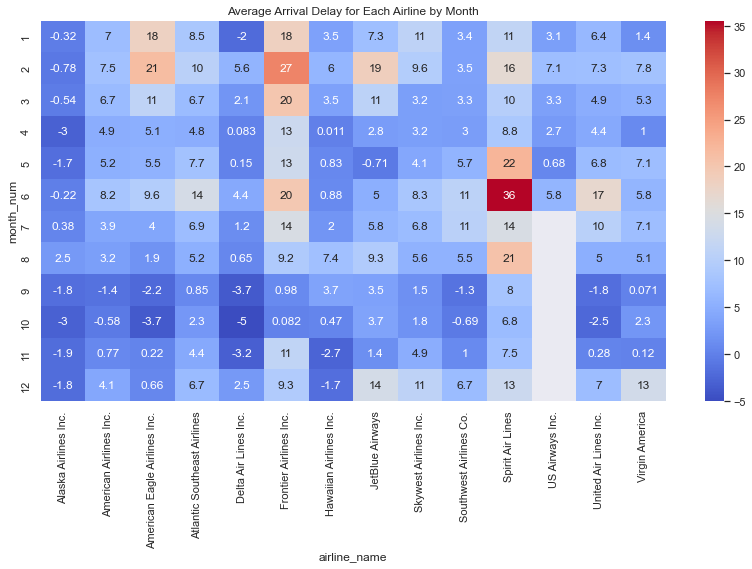

In [27]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Average Arrival Delay for Each Airline by Month")

# Heatmap showing average arrival delay for each airline by month
heat = sns.heatmap(
    data=h, 
    annot=True,
    cmap="coolwarm"
)

# Relationship between airport and delays

Start by examining how many airports each airline visits

In [28]:
g = pd.concat([
    flights[['airline_name', 'origin_airport']].rename(columns={'origin_airport': 'airport'}),
    flights[['airline_name', 'destination_airport']].rename(columns={'destination_airport': 'airport'})
])

g = g[['airline_name', 'airport']].drop_duplicates()
g = g.groupby(['airline_name']).size().reset_index()
g.columns = ['airline_name', 'count']

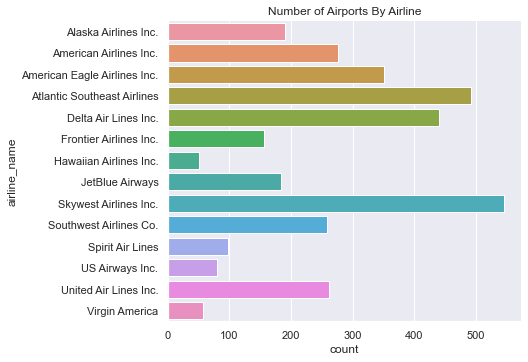

In [29]:
bar = sns.catplot(
    data=g, 
    x="count", 
    y="airline_name", 
    kind="bar",
    aspect=1.5
).set(
    title="Number of Airports By Airline"
)

Produce a heatmap of delays by origin airport

In [30]:
airports.head(2)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819


In [31]:
g = flights[['airline_name', 'origin_airport', 'arrival_delay']].rename(columns={'origin_airport': 'airport'})

avg_delay = g.groupby(['airport', 'airline_name']).mean().reset_index()

avg_delay = avg_delay.merge(airports[['IATA_CODE', 'AIRPORT']], how='left', left_on='airport', right_on='IATA_CODE')

avg_delay = avg_delay.drop(columns=['airport', 'IATA_CODE'], axis=1)

avg_delay = avg_delay.rename(columns={'AIRPORT': 'airport'})

avg_delay = avg_delay.dropna()

avg_delay.sample(10)

,airline_name,arrival_delay,airport
2297,Atlantic Southeast Airlines,10.138987,Burlington International Airport
2875,Delta Air Lines Inc.,-1.886957,Harrisburg International Airport
2994,Southwest Airlines Co.,7.470887,Oakland International Airport
3196,American Eagle Airlines Inc.,2.272945,Rochester International Airport
2696,Skywest Airlines Inc.,10.997124,Wichita Dwight D. Eisenhower National Airport ...
2908,American Airlines Inc.,7.559365,Miami International Airport
2886,American Airlines Inc.,8.607984,Memphis International Airport
2244,Delta Air Lines Inc.,-8.205776,Bismarck Municipal Airport
2709,American Eagle Airlines Inc.,4.112283,Indianapolis International Airport
2532,Skywest Airlines Inc.,303.500000,Newark Liberty International Airport


### Reshape the data

In [32]:
h = avg_delay.set_index(['airport', 'airline_name'])['arrival_delay'].unstack()
h

airline_name,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
airport,,,,,,,,,,,,,,
Aberdeen Regional Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.909502,NaN,NaN,NaN,NaN,NaN
Abilene Regional Airport,NaN,NaN,3.272075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abraham Lincoln Capital Airport,NaN,NaN,9.850427,-0.604863,NaN,NaN,NaN,NaN,10.531447,NaN,NaN,NaN,NaN,NaN
Adak Airport,11.034091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akron-Canton Regional Airport,NaN,NaN,NaN,4.997306,-4.034483,NaN,NaN,NaN,12.363636,-0.955641,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yakutat Airport,-5.632308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yampa Valley Airport (Yampa Valley Regional),NaN,7.318182,NaN,-0.125000,2.242105,NaN,NaN,NaN,15.233051,NaN,NaN,NaN,7.364238,NaN
Yeager Airport,NaN,NaN,NaN,12.390411,-0.226115,NaN,NaN,NaN,16.871795,NaN,8.75,NaN,NaN,NaN


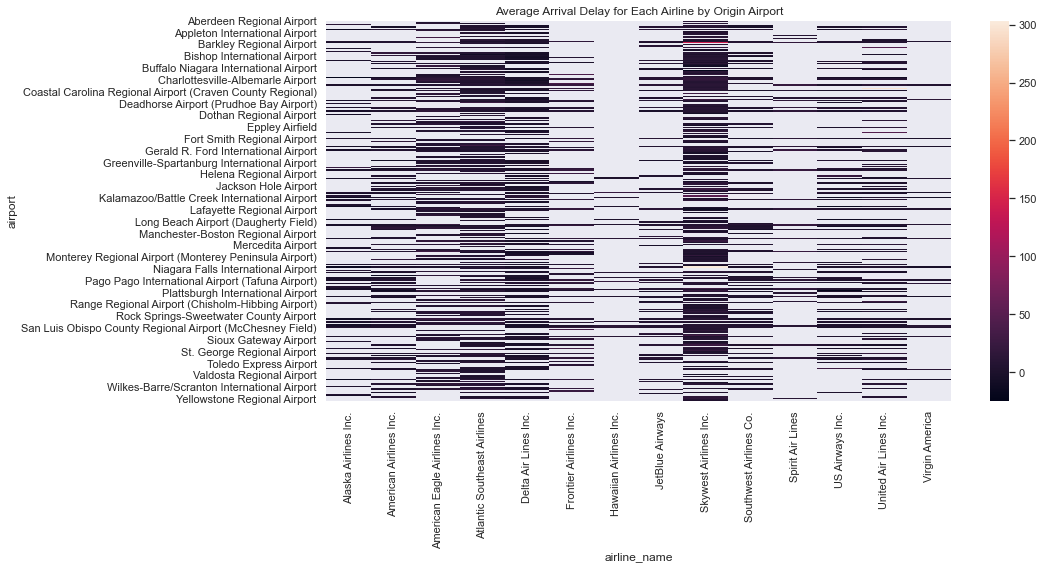

In [33]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Average Arrival Delay for Each Airline by Origin Airport")

# Heatmap showing average arrival delay for each airline by month
heat = sns.heatmap(
    data=h,
)